# Ensamble: Boosting

Podemos encontrar la documentacion en:  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, ensemble

from preprocessing import cargarDatasets
from preprocessing import prepararSetDeEntrenamiento
from preprocessing import prepararSetDeValidacion
from preprocessing import ingenieriaDeFeauturesArboles1
from preprocessing import ingenieriaDeFeauturesArboles2

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV

## Carga y preprocesamiento de datos
Cargamos los datasets y los preparamos para entrenar.

In [16]:
train_df,final_df = cargarDatasets()
train_df = prepararSetDeEntrenamiento(train_df)
final_df = prepararSetDeValidacion(final_df)

Como sabemos, boosting es un ensamble que usa arboles de decision como estimadores. Es por eso que vamos a utilizar los preprocesamientos que usamos para el modelo de arbol solo. 

In [17]:
X,y,df,y_encoder = ingenieriaDeFeauturesArboles1(train_df)
X_reducido,y_reducido,df_reducido,y_encoder_reducido = ingenieriaDeFeauturesArboles2(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reducido, y_reducido, random_state=117, test_size=0.1, stratify=y_reducido)

## Hiperparametros
(estos me parecieron los mas importantes)
* loss function
* learning_rate
* n_estimators: The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
* criterion: valores posibles -> ‘friedman_mse’, ‘mse’, ‘mae’
* min_samples_split
* min_samples_leaf
* max_depth

In [18]:
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
#https://www.quora.com/In-what-situations-do-neural-networks-outperform-gradient-boosting-and-random-forest-models-on-regular-numeric-and-categorical-data-non-image-or-text-data-if-any

#Como trabaja con arboles, los hiperparametros van a ser similares a los del arbol (tal vez podemos 
#No uso muchos parametros porque el boost es algo lento de entrenar. 
params = [{
    "loss" : ['exponential','deviance'], "criterion" : ['mse', 'friedman_mse'],
    'min_samples_leaf' : [3,10,20], "n_estimators" : [100,150]
}]


In [19]:
boost = ensemble.GradientBoostingClassifier(random_state = 0, loss = 'exponential', criterion = 'mse', 
                                              min_samples_leaf = 20)
boost2 = ensemble.GradientBoostingClassifier(random_state = 0)

In [20]:
boost.fit(X_train_r, y_train_r)

GradientBoostingClassifier(criterion='mse', loss='exponential',
                           min_samples_leaf=20, random_state=0)

In [21]:
#no probe esto todavia

rdSearch = RandomizedSearchCV(
    boost2, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, n_iter = 10, verbose = 99
).fit(X_train_r, y_train_r)
print(f"Best score: {rdSearch.best_score_}")
print(f"Best params {rdSearch.best_params_}")

NameError: name 'RandomizedSearchCV' is not defined

In [22]:
y_pred = boost.predict(X_test_r)

## Evaluacion de metricas
Analizamos primero el reporte de clasificacion.

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test_r, boost.predict(X_test_r)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2473
           1       0.75      0.59      0.66       784

    accuracy                           0.85      3257
   macro avg       0.81      0.76      0.78      3257
weighted avg       0.85      0.85      0.85      3257



**CONCLUSION**

### AUC-ROC score

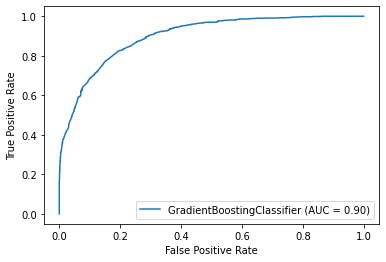

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

plot_roc_curve(boost,X_test_r,y_test_r,response_method='predict_proba')
plt.show()

Podemos observar que el modelo tiene un 0.9 de probabilidad de distinguir correctamente las clases.

### Recall

In [31]:
recall_score(y_test_r, y_pred)

0.5880102040816326

### Precision

In [32]:
precision_score(y_test_r,y_pred)

0.7495934959349594

### Accuracy

In [34]:
accuracy_score(y_test_r, y_pred) 

0.8535462081670249

### Matriz de confusion

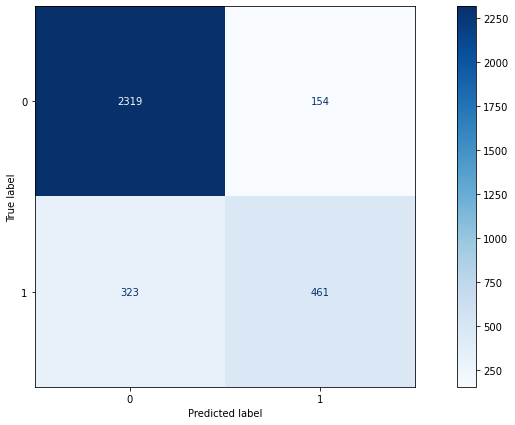

In [37]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    boost, X_test_r, y_test_r, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax
)

plt.show()